## Step 1: Data Loading and Initial Exploration

In this step, we load the dataset from the provided zip file and explore its structure. This helps us understand the data, its columns, and any potential issues (e.g., missing values or incorrect data types).

In [ ]:
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
def load_dataset(zip_path, csv_filename):
    """
    Loads a dataset from a zip file and returns it as a pandas DataFrame.

    Args:
        zip_path (str): Path to the zip file.
        csv_filename (str): Name of the CSV file inside the zip.

    Returns:
        pd.DataFrame: Loaded dataset.
    """
    with zipfile.ZipFile(zip_path, 'r') as z:
        with z.open(csv_filename) as f:
            df = pd.read_csv(f, encoding='latin1')  # Latin1 for special characters
    return df

# Load the dataset
zip_path = '/content/Online Retail II UCI.zip'  # Path to the uploaded zip file
csv_filename = 'online_retail_II.csv'  # Update this if the file has a different name
dataset = load_dataset(zip_path, csv_filename)

# Display basic info and the first few rows
def explore_dataset(dataset):
    """
    Prints basic information about the dataset and its first few rows.

    Args:
        dataset (pd.DataFrame): The dataset to explore.
    """
    print("Dataset Information:")
    print(dataset.info())
    print("\nFirst 5 Rows:")
    print(dataset.head())

explore_dataset(dataset)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB
None

First 5 Rows:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         

## Step 2: Data Cleaning and Preprocessing

In this step, the dataset is cleaned by:
1. Removing rows with missing `Customer ID`.
2. Converting `InvoiceDate` into a proper datetime format.
3. Removing invalid rows where `Quantity` or `Price` are zero or negative.
4. Deduplicating the dataset to ensure data integrity.

In [6]:
def clean_dataset(df):

    # Droping rows with missing Customer IDs
    df = df.dropna(subset=['Customer ID'])

    # Converting InvoiceDate to datetime format
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

    # Remove rows with negative or zero Quantity or Price
    df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

    # Removing duplicates
    df = df.drop_duplicates()

    return df

# Cleaning the dataset
cleaned_dataset = clean_dataset(dataset)

print("Cleaned Dataset Information:")
print(cleaned_dataset.info())
print("\nFirst 5 Rows of Cleaned Dataset:")
print(cleaned_dataset.head())

<ipython-input-6-0a82e523e476>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')


Cleaned Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 779425 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      779425 non-null  object        
 1   StockCode    779425 non-null  object        
 2   Description  779425 non-null  object        
 3   Quantity     779425 non-null  int64         
 4   InvoiceDate  779425 non-null  datetime64[ns]
 5   Price        779425 non-null  float64       
 6   Customer ID  779425 non-null  float64       
 7   Country      779425 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 53.5+ MB
None

First 5 Rows of Cleaned Dataset:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W               

## Step 3: Data Exploration and Visualization

In this step, we visualize key aspects of the cleaned dataset:
1. A bar chart to show the top-selling products or categories.
2. A line graph to observe trends over time, such as total sales by month.
3. A heatmap to analyze correlations between features like `Quantity`, `Price`, and `Total Sales`.

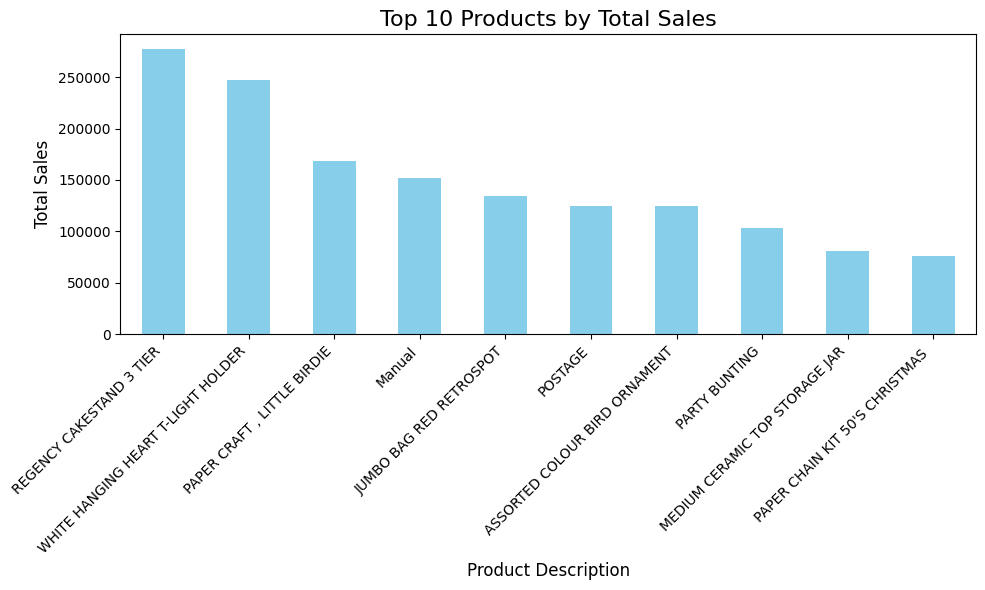

In [7]:
def visualize_top_products(df):

    # Calculate total sales for each product
    df['TotalSales'] = df['Quantity'] * df['Price']
    top_products = df.groupby('Description')['TotalSales'].sum().sort_values(ascending=False).head(10)

    # Bar plot for top products
    plt.figure(figsize=(10, 6))
    top_products.plot(kind='bar', color='skyblue')
    plt.title('Top 10 Products by Total Sales', fontsize=16)
    plt.xlabel('Product Description', fontsize=12)
    plt.ylabel('Total Sales', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Call the function
visualize_top_products(cleaned_dataset)


## Step 3.2: Visualizing Time-Based Trends

To understand how sales vary over time, we analyze the total sales aggregated by month. This allows us to observe seasonal patterns, trends, and fluctuations.

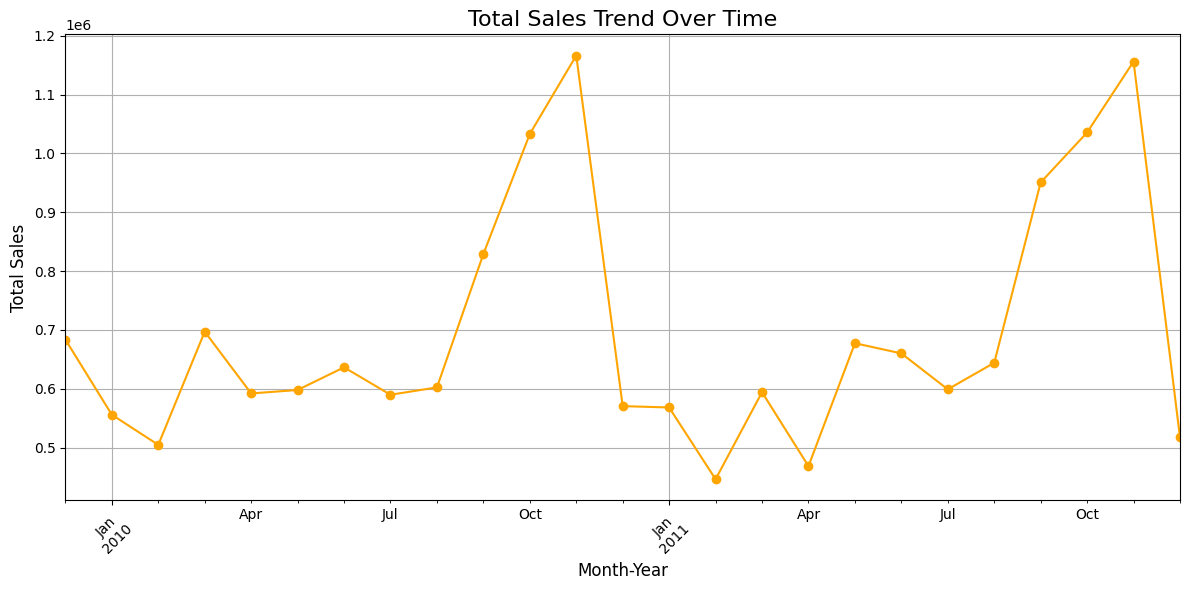

In [8]:
def visualize_sales_trend(df):
    """
    Visualizes total sales trends over time by aggregating sales by month.

    Args:
        df (pd.DataFrame): The cleaned dataset with 'InvoiceDate' and 'TotalSales'.

    Returns:
        None
    """
    # Ensure TotalSales column exists
    if 'TotalSales' not in df.columns:
        df['TotalSales'] = df['Quantity'] * df['Price']

    # Extract month and year from InvoiceDate
    df['MonthYear'] = df['InvoiceDate'].dt.to_period('M')

    # Aggregate sales by month
    monthly_sales = df.groupby('MonthYear')['TotalSales'].sum()

    # Plot sales trend
    plt.figure(figsize=(12, 6))
    monthly_sales.plot(kind='line', marker='o', color='orange')
    plt.title('Total Sales Trend Over Time', fontsize=16)
    plt.xlabel('Month-Year', fontsize=12)
    plt.ylabel('Total Sales', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function
visualize_sales_trend(cleaned_dataset)


## Step 3.3: Feature Correlation Analysis (Heatmap)

To identify relationships between numerical features, we use a correlation heatmap. This helps determine how variables like `Quantity`, `Price`, and `Total Sales` are related, which can inform further analysis.

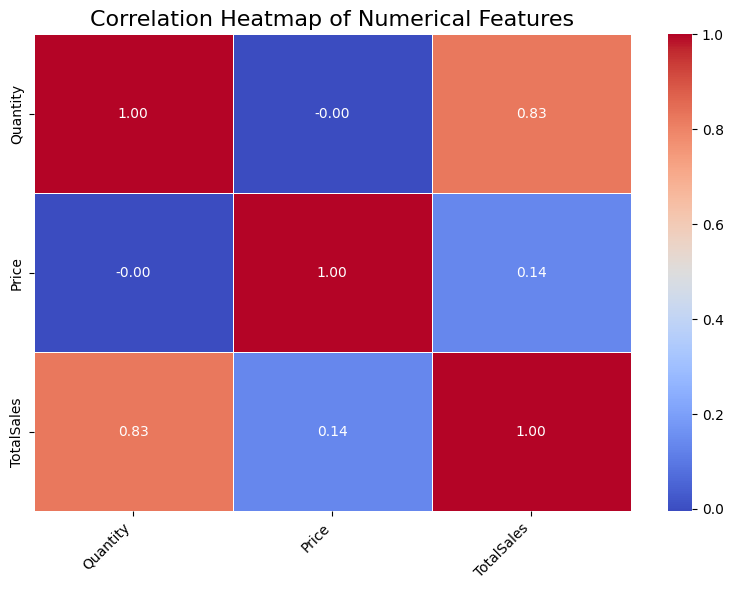

In [9]:
def visualize_correlation_heatmap(df):
    """
    Visualizes a correlation heatmap for numerical features in the dataset.

    Args:
        df (pd.DataFrame): The cleaned dataset with numerical features.

    Returns:
        None
    """
    # Ensure TotalSales column exists
    if 'TotalSales' not in df.columns:
        df['TotalSales'] = df['Quantity'] * df['Price']

    # Select numerical columns for correlation
    numerical_features = df[['Quantity', 'Price', 'TotalSales']]
    correlation_matrix = numerical_features.corr()

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Call the function
visualize_correlation_heatmap(cleaned_dataset)

## Step 4: Clustering Analysis

In this step, we cluster data to uncover hidden patterns or segments:
1. Normalize numerical features (`Quantity`, `Price`, `TotalSales`) to standardize their scales.
2. Use the elbow method to determine the optimal number of clusters.
3. Apply K-Means clustering and visualize the results in a 2D space.

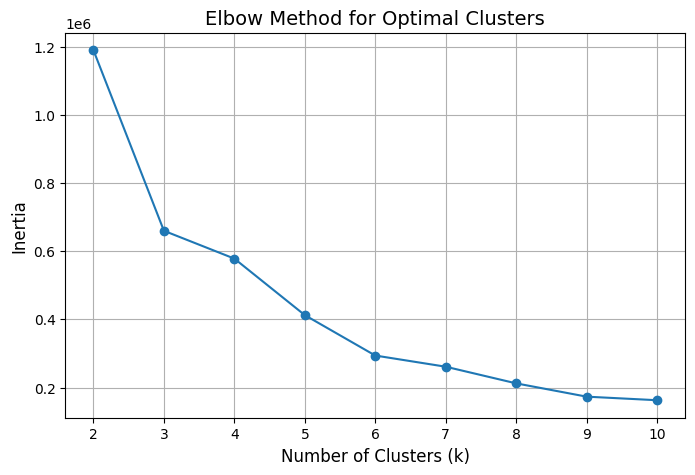

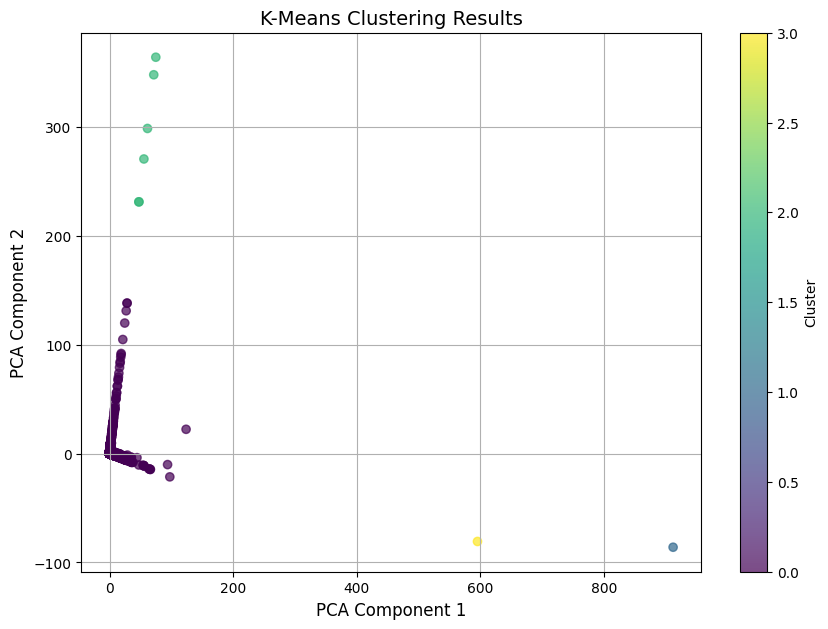

In [10]:
def perform_clustering(df):
    """
    Performs clustering on normalized numerical features using K-Means
    and visualizes clusters in a 2D space.

    Args:
        df (pd.DataFrame): The cleaned dataset.

    Returns:
        None
    """
    # Normalize numerical features
    features = df[['Quantity', 'Price', 'TotalSales']]
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)

    # Determine optimal clusters using Elbow Method
    inertias = []
    K = range(2, 11)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(normalized_features)
        inertias.append(kmeans.inertia_)

    # Plot Elbow Method
    plt.figure(figsize=(8, 5))
    plt.plot(K, inertias, marker='o')
    plt.title('Elbow Method for Optimal Clusters', fontsize=14)
    plt.xlabel('Number of Clusters (k)', fontsize=12)
    plt.ylabel('Inertia', fontsize=12)
    plt.grid(True)
    plt.show()

    # Apply K-Means clustering
    optimal_k = 4  # Assume from the elbow plot
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    clusters = kmeans.fit_predict(normalized_features)
    df['Cluster'] = clusters

    # Visualize clusters in 2D using PCA
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(normalized_features)
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Cluster')
    plt.title('K-Means Clustering Results', fontsize=14)
    plt.xlabel('PCA Component 1', fontsize=12)
    plt.ylabel('PCA Component 2', fontsize=12)
    plt.grid(True)
    plt.show()

# Call the function
perform_clustering(cleaned_dataset)


## Step 5: Regression Analysis

In this step, we build a regression model to predict total sales (`TotalSales`) based on features like `Quantity` and `Price`. The steps include:
1. Splitting the data into training and testing sets.
2. Training a linear regression model.
3. Evaluating the model's performance using metrics like R-squared.
4. Visualizing predicted vs. actual sales.

Mean Squared Error: 4906.56
R-squared: 0.04


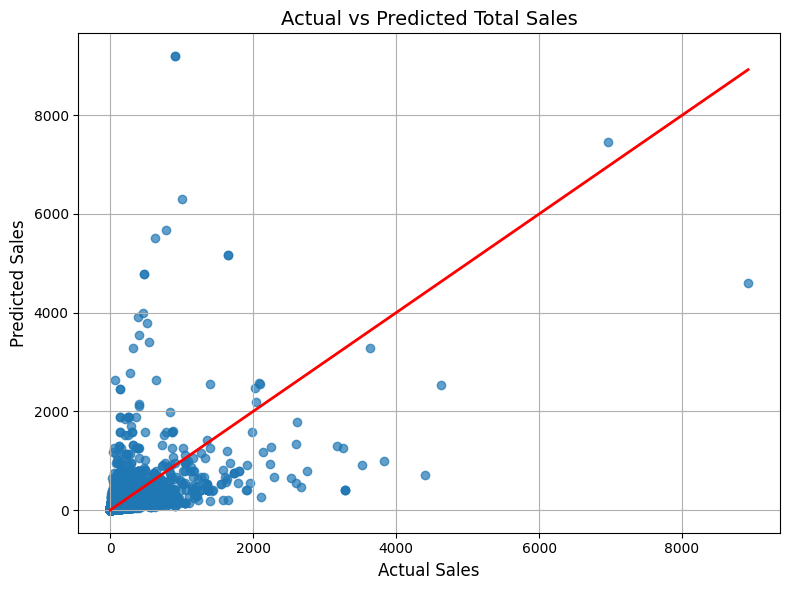

In [11]:
def perform_regression(df):
    """
    Performs regression analysis to predict TotalSales and evaluates model performance.

    Args:
        df (pd.DataFrame): The cleaned dataset.

    Returns:
        None
    """
    # Features and target
    X = df[['Quantity', 'Price']]  # Features
    y = df['TotalSales']          # Target

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Evaluate model performance
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R-squared: {r2:.2f}")

    # Visualize predictions vs actuals
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
    plt.title('Actual vs Predicted Total Sales', fontsize=14)
    plt.xlabel('Actual Sales', fontsize=12)
    plt.ylabel('Predicted Sales', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function
perform_regression(cleaned_dataset)

## Step 6: Future Predictions

In this step, we use the trained regression model to predict `TotalSales` for hypothetical feature values (e.g., `Quantity` and `Price`). This demonstrates the model's ability to generalize to unseen data.

In [13]:
# Ensure the model and scaler are properly trained and passed to the function
# This step reuses the regression model and scaler from the previous step.

# Retrain the model (if not already available)
X = cleaned_dataset[['Quantity', 'Price']]
y = cleaned_dataset['TotalSales']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict future sales with the corrected code
def predict_future_sales(model, scaler, quantity_price_pairs):

    # Normalize the new feature values
    normalized_data = scaler.transform(quantity_price_pairs)

    # Predict TotalSales
    predictions = model.predict(normalized_data)

    # Create a DataFrame for display
    results = pd.DataFrame(quantity_price_pairs, columns=['Quantity', 'Price'])
    results['Predicted TotalSales'] = predictions
    return results

# Example future data
future_data = [
    [10, 5.0],  # Example 1: Quantity = 10, Price = $5.0
    [20, 3.5],  # Example 2: Quantity = 20, Price = $3.5
    [5, 10.0],  # Example 3: Quantity = 5, Price = $10.0
]

# Make predictions
future_predictions = predict_future_sales(model, scaler, future_data)

# Display predictions
print("Future Predictions:")
print(future_predictions)

Future Predictions:
   Quantity  Price  Predicted TotalSales
0        10    5.0             19.589263
1        20    3.5             31.108466
2         5   10.0             18.387518


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
